## Case Study: Prediction of Graduate Admissions

<img src="admission.jpg" width=500 height = 280/>

**Data to be used**: `Admission_Predict.csv`

Following is the description of columns in `Admission_Predict.csv` file:

<TABLE CAPTION="Mobile Dataset">
<TR><TD><B>Variable</B></TD><TD><B>Description</B></TD></TR>
<TR><TD>GRE Score</TD><TD>GRE Scores (out of 340)</TD></TR>
<TR><TD>TOEFL Score</TD><TD>TOEFL Scores (out of 120)</TD></TR>
<TR><TD>University Rating</TD><TD>University Rating (out of 5)</TD></TR>
<TR><TD>SOP</TD><TD>Quality of Statement of Purpose (out of 5)</TD></TR>
<TR><TD>LOR</TD><TD>Quality of Letters of Recommendation (out of 5)</TD></TR>
<TR><TD>CGPA</TD><TD>Undergraduate GPA (out of 10)</TD></TR>   
<TR><TD>Research</TD><TD>Research Experience (either Yes or No)</TD></TR>
<TR><TD>Chances of Admit</TD><TD>Chance of Admit (ranging from 0 to 1)</TD></TR>
</TABLE>

### Import Libraries

In [19]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import sklearn
from sklearn.ensemble import RandomForestRegressor # Random Forest

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

**Install MAPIE via `pip`**:

`!pip install mapie`

### Load Dataset

In [20]:
# Import Data
df = pd.read_csv('Admission_Predict.csv')
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,Yes,0.92
1,324,107,4,4.0,4.5,8.87,Yes,0.76
2,316,104,3,3.0,3.5,8.00,Yes,0.72
3,322,110,3,3.5,2.5,8.67,Yes,0.80
4,314,103,2,2.0,3.0,8.21,No,0.65


In [21]:
# Select input and output features
X = df.drop(columns = ['Chance of Admit'])
y = df['Chance of Admit']

In [22]:
# One hot encoding for categorical variables
X_encoded = pd.get_dummies(X)
X_encoded.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research_No,Research_Yes
0,337,118,4,4.5,4.5,9.65,False,True
1,324,107,4,4.0,4.5,8.87,False,True
2,316,104,3,3.0,3.5,8.00,False,True
3,322,110,3,3.5,2.5,8.67,False,True
4,314,103,2,2.0,3.0,8.21,True,False


In [23]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

### Implement Random Forest Regressor

In [24]:
# Define your model
reg = RandomForestRegressor(random_state = 42)

In [25]:
# Fit the model
start = time.time()            # Start Time
reg.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 0.23412299156188965s


#### Evaluate Prediction Performance on Test Set

In [26]:
# Predict Test Set
y_pred = reg.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.79
RMSE on Test Set: 0.07


#### Histogram of Residuals/Errors 

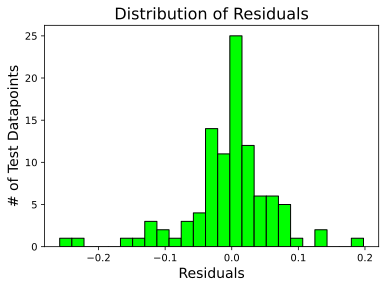

In [27]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig('residual_plot.svg')

#### Scatter Plot of Predicted Vs. Actual Values

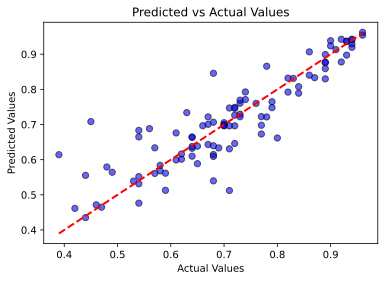

In [28]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig('pred_vs_actual.svg')

#### Feature Importance Plot

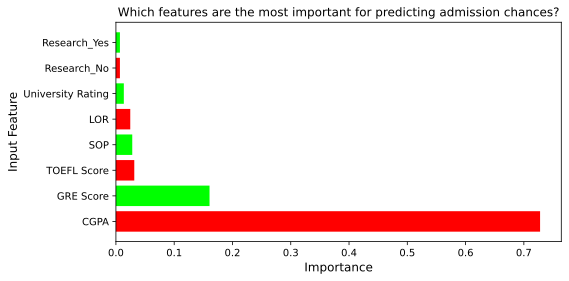

In [29]:
# Storing importance values from the trained model
importance = reg.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting admission chances?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();
plt.savefig('feature_imp.svg')

### Prediction Intervals for Regression
<img src="Prediction_Interval.png" width="500" style="float: center"/>

#### **What is a Prediction Interval?**
- It is a **range of values** within which a new observation is expected to fall with a **certain probability**, given the existing data and model.

- **Probability**: The width of the prediction interval depends on the **desired confidence level**, (e.g., 95%), with higher confidence levels leading to wider intervals.

#### **Confidence Level of Prediction Interval**

- The confidence level of a prediction interval indicates the probability that the interval will contain the true value of the parameter being estimated.

- Mathematically, the confidence level of a prediction interval is denoted by $ (1 - \alpha) \times 100\% $, where $ \alpha $ is the significance level.

#### **Why Prediction Intervals are Useful?**

- **Uncertainty Quantification**: They provide a measure of the uncertainty in individual predictions, which is crucial for risk assessment and decision-making.

- **Communication**: They are an effective tool for communicating the uncertainty in predictions to stakeholders, making the model's predictions more interpretable.

#### **Prediction Intervals using MAPIE Regressor**

***MAPIE: Model Agnostic Prediction Interval Estimator***

- It is a Python library designed to estimate prediction intervals in a **model-agnostic way**.
- It can be used with **any machine learning model**, including linear models, decision trees, ensemble methods, and neural networks.

[**See this link for detailed description on `MAPIE`**](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html)

In [30]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = reg, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 7.103766918182373s


In [31]:
# Predicted values
y_test_pred

array([0.9373, 0.7891, 0.6141, 0.6979, 0.7927, 0.8775, 0.4647, 0.6337,
       0.8457, 0.7923, 0.7083, 0.7225, 0.676 , 0.9197, 0.859 , 0.5642,
       0.8332, 0.5886, 0.5518, 0.5609, 0.6431, 0.5314, 0.7065, 0.7648,
       0.7709, 0.6146, 0.9361, 0.832 , 0.6638, 0.7295, 0.5615, 0.7264,
       0.5389, 0.8758, 0.646 , 0.747 , 0.5991, 0.9413, 0.6395, 0.6883,
       0.9542, 0.5553, 0.7005, 0.8299, 0.9384, 0.6324, 0.9426, 0.8077,
       0.7601, 0.9295, 0.8975, 0.5396, 0.673 , 0.4763, 0.9428, 0.6372,
       0.9623, 0.7338, 0.6335, 0.4351, 0.6092, 0.7052, 0.6162, 0.5122,
       0.4714, 0.5791, 0.8993, 0.9067, 0.6968, 0.6962, 0.6099, 0.748 ,
       0.6966, 0.5838, 0.568 , 0.6013, 0.8312, 0.8658, 0.5127, 0.6647,
       0.6617, 0.8779, 0.6383, 0.8403, 0.7221, 0.6642, 0.6308, 0.7488,
       0.7216, 0.6966, 0.7605, 0.9238, 0.9131, 0.7006, 0.7693, 0.4614,
       0.6963, 0.746 , 0.7217, 0.6833])

In [32]:
# Prediction Intervals
y_test_pis

array([[[0.824 ],
        [1.0494]],

       [[0.6697],
        [0.8959]],

       [[0.4883],
        [0.7125]],

       [[0.593 ],
        [0.8238]],

       [[0.6814],
        [0.914 ]],

       [[0.7636],
        [0.9898]],

       [[0.3547],
        [0.5928]],

       [[0.5212],
        [0.7521]],

       [[0.7324],
        [0.9568]],

       [[0.6705],
        [0.9009]],

       [[0.6056],
        [0.8311]],

       [[0.6091],
        [0.8348]],

       [[0.5555],
        [0.7837]],

       [[0.81  ],
        [1.0364]],

       [[0.7449],
        [0.9701]],

       [[0.4201],
        [0.6554]],

       [[0.7151],
        [0.9387]],

       [[0.484 ],
        [0.7094]],

       [[0.426 ],
        [0.6563]],

       [[0.4303],
        [0.6589]],

       [[0.5351],
        [0.7654]],

       [[0.4016],
        [0.6399]],

       [[0.6011],
        [0.8249]],

       [[0.6478],
        [0.8747]],

       [[0.647 ],
        [0.8752]],

       [[0.5027],
        [0.7314]],

       [[0.8

In [33]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
347,0.42,0.46,0.35,0.58
86,0.72,0.70,0.59,0.82
75,0.72,0.75,0.62,0.85
438,0.67,0.72,0.61,0.83
15,0.54,0.68,0.57,0.79


### **Coverage Calculation**
- **Coverage** refers to the proportion of true/actual values that fall within the prediction intervals generated by a model.

- It is a measure of how well the prediction intervals capture the actual values.

  $\text{Coverage} = \frac{\text{Number of actual values within prediction intervals}}{\text{Total number of actual values}}$

In [34]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 92.00%


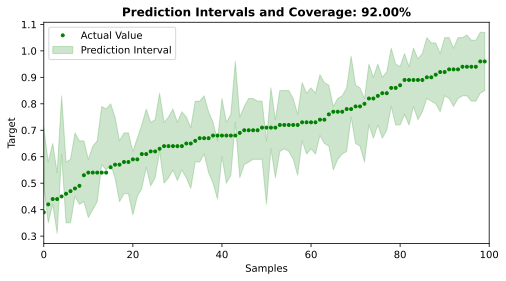

In [35]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);
plt.savefig('coverage.svg')

### Save Model

In [36]:
# Creating the file where we want to write the model
reg_pickle = open('reg_admission.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, reg_pickle) 

# Close the file
reg_pickle.close()